# Análisis exploratorio de los datos de GoFoundMe

En este cuaderno se muestra la exploración de datos que fueron obtenidos mediante *web scrapping* de GoFoundMe.

Primero, importamos las bibliotecas que usaremos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from currency_converter import CurrencyConverter
c = CurrencyConverter()

In [2]:
# Para usar el estilo por defecto de seaborn
sns.set(rc={'figure.figsize':(11, 5)})
sns.set_style("white") #ponemos el fondo blanco

## Se cargan y se limpian los datos:

In [3]:
df = pd.read_csv('../datos/datos_GoFundMe.csv', parse_dates = ['launch_date'], index_col= 0) #versión final

# nos asegutamos que la columna_count tenga formato numerico
df['donation_count'] = pd.to_numeric(df['donation_count'])

# Todos los tags: 'salud' los incluimos en 'Medical, Illness & Healing'
df.loc[df['tags'] == 'salud', 'tags'] = 'Medical, Illness & Healing'

# filtramos fechas que no corresponden a nuestro rango de interés
filtro = df['launch_date'] > '2020-01-01'
df = df[filtro]

df.head() #echamos un primer vistazo

,tags,current amount,total_amount,created,launch_date,country,donation_count,is_charity
0,"Medical, Illness & Healing","$17,550","$50,000","Created April 2, 2021",2021-04-02,US,174,False
1,Volunteer & Service,"$5,730","$6,000","Created April 13, 2020",2020-04-13,US,148,False
2,"Medical, Illness & Healing","$5,350","$5,000","Created April 25, 2020",2020-04-25,US,142,False
3,"Medical, Illness & Healing","$3,239","$8,000","Created April 6, 2021",2021-04-06,US,37,False
4,Animals & Pets,"€1,050","€1,800","Created July 5, 2020",2020-07-05,US,32,False


### Limpieza de divisas

Antes que todo, verifiquemos que los datos estén completos:

In [4]:
# sub df de datos con valores nulos para la variable 'total_amount'
df[pd.isnull(df['total_amount'])]

,tags,current amount,total_amount,created,launch_date,country,donation_count,is_charity


Vemos que no hace falta ningún valor. 

Algo de lo que nos percatamos es que el dinero no se solicita en la misma divisa. Para solucionar esto, se identifican los signos de todas las divisas presentes en nuestros datos. En este orden de ideas, se crea una función que recibe una lista/arreglo/serie de cantidades de dinero expresadas en diferentes divisas y devuelve la lista de símbolos de cada una de estas divisas:

In [5]:
def lista_signos(dinero):
    signos = []
    for string in dinero:
        signo = ''
        string = str(string)
        for char in string:
            if char.isnumeric():
                break
            else:
                signo += char
        if signo == '':
            signo = 'no registra'
        signos.append(signo) 
    return signos

Identificamos los símbolos para las cantidades de dinero en las columnas: *current amount*, *total_amount*

In [6]:
#current amount
signos_current = np.array(lista_signos(df['current amount']))

#total_amount
signos_total = np.array(lista_signos(df['total_amount']))

#veamos cuáles signos se encuentra en cada caso
print(set(signos_current), set(signos_total))

{'$', 'no registra', 'CHF', 'kr', '£', '€'} {'$', 'CHF', 'kr', '€', '£'}


Exploremos las filas que no registran valor en la columna *current amount*:

In [7]:
df[signos_current == 'no registra'].head(3)

,tags,current amount,total_amount,created,launch_date,country,donation_count,is_charity
60,"Medical, Illness & Healing","1,796",$,"Created July 29, 2020",2020-07-29,US,51,False
71,"Medical, Illness & Healing",140,$,"Created April 11, 2021",2021-04-11,US,10,False
75,"Medical, Illness & Healing",142,€,"Created February 18, 2021",2021-02-18,US,7,False


Para los demás filas, verifiquemos que los signos de ambas columnas concuerdan:

In [8]:
# filtro para las columnas en las que sí se registra el signo en la columna: current amount
filtro = np.array(signos_current) != 'no registra'

sum(signos_current[filtro] != signos_total[filtro]) # el resultado de esta suma es el número de filas con incongruencias

0

Vemos que en todas las demás filas concuerdan, por lo tanto, se asumirá que la divisa que se utiliza en la columna *current amount* es la misma que se usa en la columna *total_amount*. Con esta información, se modificará el DataFrame para que sea más fácil generar resultados. Los cambios que se planean hacer son los siguientes:
1. Agregar una columna en donde se señale la divisa que se usa en la campaña.
2. Modificar las columnas *current amount* y *total_amount* para que cada entrada corresponda alvalor numérico de los montos.
3. Agregar dos columnas: *current amount in dollars*, *total amount in dollars* con los valores monetarios en dolares.
4. Agregar otra columna: *percentage of completion*, que cuantifica cuanto ha avanzado la campaña.

Cabe mencionar, que para cumplir estos objetivos se usará la biblioteca `currency_converter`.

Empezamos con el primer punto:

In [9]:
monedas = []
for signo in signos_total:
    if signo == 'CHF':
        monedas.append('CHF')
    elif signo == 'kr':
        monedas.append('SEK')
    elif signo == '$':
        monedas.append('USD')
    elif signo == '£':
        monedas.append('GBP')
    elif signo == '€':
        monedas.append('EUR')

#agregamos la columna de códigos
df.insert(3, 'currency used', monedas)

Para el segundo punto, creamos una función:

In [10]:
def modificar_columna_dinero(DataFrame, nombre_columna, signos):
    col = df.columns.get_loc(nombre_columna)
    n = len(DataFrame.index)
    for i in range(n):
        valor = DataFrame.iloc[i, col]
        valor = valor.replace(signos[i], '').replace(',', '') #quitamos el signo y la coma
        if valor.isnumeric():
            valor = int(valor)
        else:
            valor = np.nan # sabemos que los único nan que estén presentes en los datos
                           # serán los que se agreguen en este paso.
        DataFrame.iloc[i, col] = valor

In [11]:
# con la función que creamos, modificamos las columnas
modificar_columna_dinero(df, 'current amount', signos_current)
modificar_columna_dinero(df, 'total_amount', signos_total)

En el tercer paso se utilizará la biblioteca `currency converter`. Para evitar ambigüedades se tomará como referencia el valor del dólar del día 3 de marzo de 2021, que es el último día disponible en la biblioteca:

In [12]:
current_dolares = np.array([])
total_dolares = np.array([])
n = len(df.index)
for i in range(n):
    # usamos la última fecha disponible en la biblioteca para hacer el cambio a dolares
    current_dolares = np.append(current_dolares, c.convert(df['current amount'].iloc[i], df['currency used'].iloc[i], 
                                     'USD', pd.to_datetime('2021-03-09'))) 
    total_dolares = np.append(total_dolares, c.convert(df['total_amount'].iloc[i], df['currency used'].iloc[i], 
                                   'USD', pd.to_datetime('2021-03-09')))

#agregamos las nuevas columnas:
df.insert(4, 'current amount in dollars', current_dolares)
df.insert(5, 'total amount in dollars', total_dolares)

Por por último, insertamos la columna: *percentage of completion*

In [13]:
df.insert(6, 'percentage of completion', (current_dolares/total_dolares)*100)

Visualicemos el resultado final:

In [14]:
df.head()

,tags,current amount,total_amount,currency used,current amount in dollars,total amount in dollars,percentage of completion,created,launch_date,country,donation_count,is_charity
0,"Medical, Illness & Healing",17550,50000,USD,17550.00,50000.00,35.100000,"Created April 2, 2021",2021-04-02,US,174,False
1,Volunteer & Service,5730,6000,USD,5730.00,6000.00,95.500000,"Created April 13, 2020",2020-04-13,US,148,False
2,"Medical, Illness & Healing",5350,5000,USD,5350.00,5000.00,107.000000,"Created April 25, 2020",2020-04-25,US,142,False
3,"Medical, Illness & Healing",3239,8000,USD,3239.00,8000.00,40.487500,"Created April 6, 2021",2021-04-06,US,37,False
4,Animals & Pets,1050,1800,EUR,1248.87,2140.92,58.333333,"Created July 5, 2020",2020-07-05,US,32,False


## Visualización de datos:

**Distribución de variables:**
* Paises
* Monedas
* Tags

**Distribución de variables (agregados y por tags):**
* Monto total
* Monto actual 
* Tasa de avance recaudado 
* Tasa de adquisición donantes 

**Series de tiempo** 

Diferenciar por tags, tres categorias:
* Todas las categorías agregadas.
* Tags: Medical, illness & Healing
* Tags: Medical, illness & Healing + Accidents & Emergencies

Variables:
* Nuevas campañas
* Monto total diaria
* Monto total promedio

### Distribución de paises:

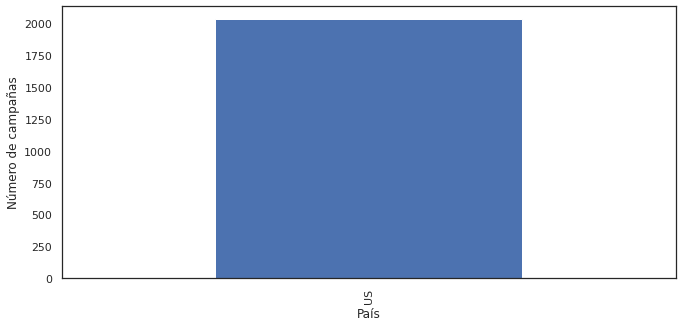

In [15]:
#visualicemos la distribución de paises
df.reset_index().groupby(['country']).count().reset_index().plot(x = 'country', y = 'index',  kind = 'bar', legend = False, 
                                                                 ylabel = 'Número de campañas', xlabel = 'País')
plt.show()

### Distribución de monedas

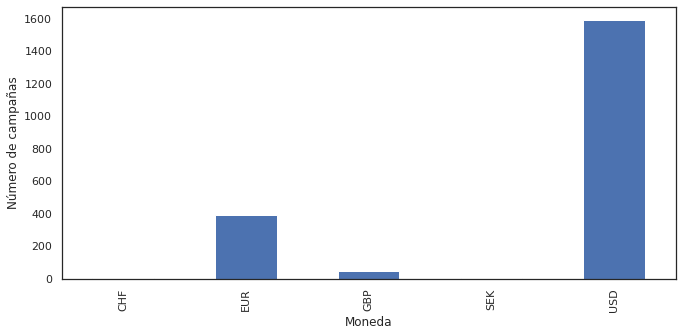

In [16]:
#visualicemos la distribución de monedas
df.reset_index().groupby(['currency used']).count().reset_index().plot(x = 'currency used', y = 'index', kind = 'bar', 
                                                                       legend = False, ylabel = 'Número de campañas', 
                                                                       xlabel = 'Moneda')
plt.show()

### Distribución de tags:

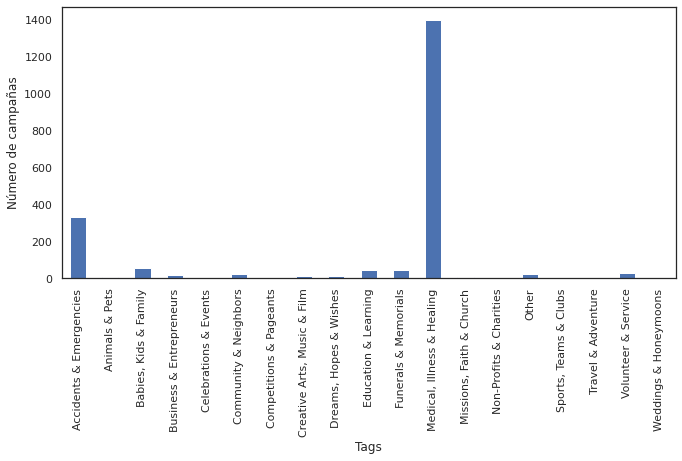

In [17]:
# visualicemos la distribución de tags
df.reset_index().groupby('tags').count().reset_index().plot(x = 'tags', y = 'index', kind = 'bar', legend = False, 
                                                            ylabel = 'Número de campañas', xlabel = 'Tags')
plt.show()

### Distribución de monto total y actual

Exploremos cuáles son las capañas más costosas

In [18]:
df.sort_values(by=['total amount in dollars'], ascending=False).head()

,tags,current amount,total_amount,currency used,current amount in dollars,total amount in dollars,percentage of completion,created,launch_date,country,donation_count,is_charity
1054,Business & Entrepreneurs,20000000,20000000,USD,2.000000e+07,2.000000e+07,100.000000,"Created March 2, 2021",2021-03-02,US,0,False
1609,NaN,350000,350000,USD,3.500000e+05,3.500000e+05,100.000000,Created 2 days ago,2021-05-09,US,0,False
1046,"Medical, Illness & Healing",250000,250000,GBP,3.469500e+05,3.469500e+05,100.000000,"Created April 12, 2021",2021-04-12,US,0,False
1310,Accidents & Emergencies,715,254000,USD,7.150000e+02,2.540000e+05,0.281496,"Created July 15, 2020",2020-07-15,US,13,False
1141,Accidents & Emergencies,5,250000,USD,5.000000e+00,2.500000e+05,0.002000,"Created November 3, 2020",2020-11-03,US,1,False


En este caso, la campaña que se encuentra en primera posición es un outlier que impide visualizar los demás datos de manera adecuada. En este orden de ideas, filtraremos este dato. 

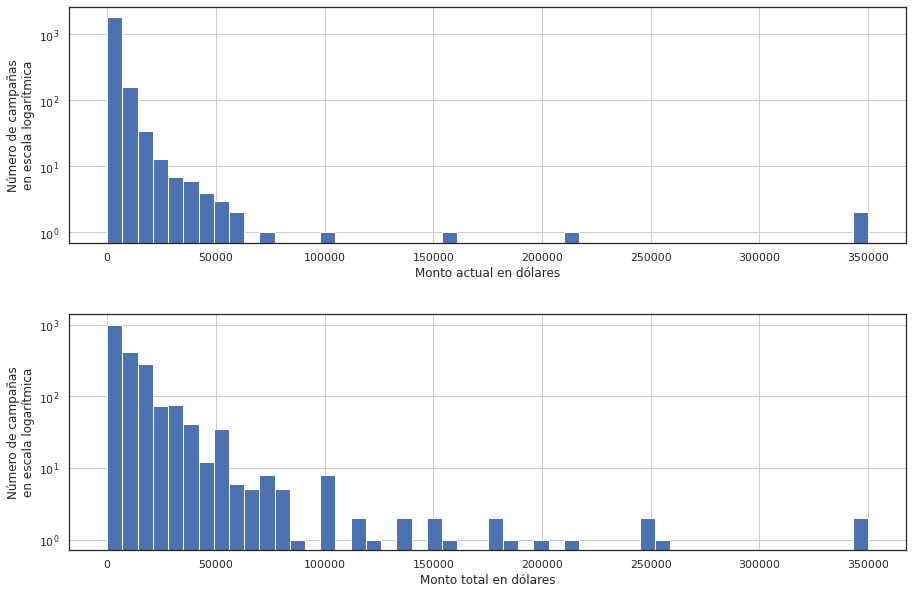

In [19]:
#arreglar esto (unique identifier)
axes = df.drop(labels=1054, axis=0).hist(column = ['current amount in dollars', 'total amount in dollars'], 
                                        bins = 50, log = True, layout = (2, 1), figsize = (15, 10))

eje_x = ['Monto actual en dólares','Monto total en dólares']
for i in range(2):
    axes[i][0].set_ylabel('Número de campañas\nen escala logarítmica')
    axes[i][0].set_xlabel(eje_x[i])
    axes[i][0].set_title('')
plt.tight_layout
plt.show()

#### Por tags:

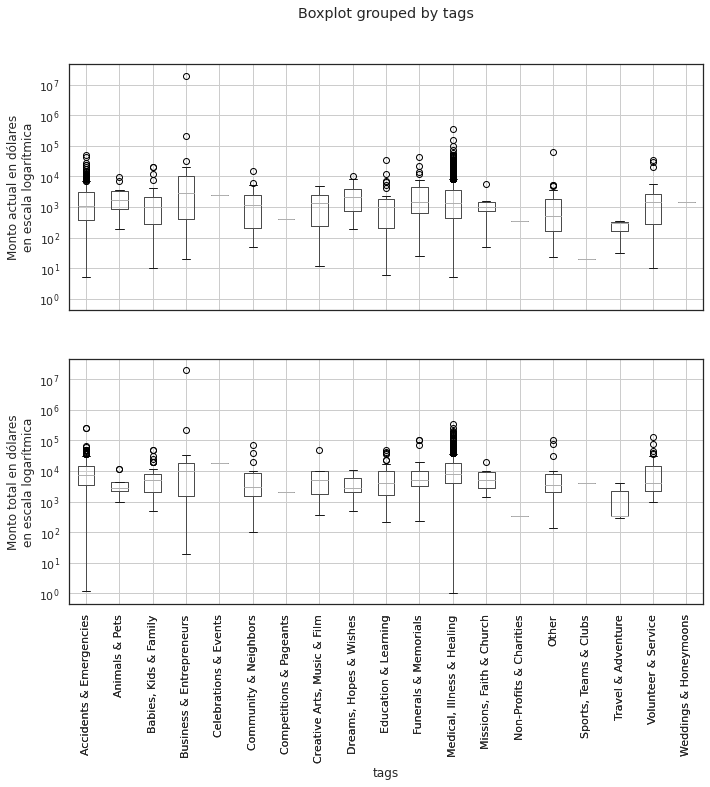

In [20]:
axes = df.boxplot(column = ['current amount in dollars', 'total amount in dollars'], by = 'tags', 
                                    layout = (2, 1), rot = 90, figsize = (11, 10))
eje_y = ['Monto actual en dólares\nen escala logarítmica','Monto total en dólares\nen escala logarítmica']
for i in range(2):
    axes[i].set_ylabel(eje_y[i])
    axes[i].set_title('')
    axes[i].set_yscale('log')
plt.show()

### Distribución de la tasa de avance de la campaña

Procedemos de manera análoga con el porcentaje de avance de la campaña:

In [21]:
df.sort_values(by=['percentage of completion'], ascending=False).head()

,tags,current amount,total_amount,currency used,current amount in dollars,total amount in dollars,percentage of completion,created,launch_date,country,donation_count,is_charity
477,"Medical, Illness & Healing",24444,1,USD,24444.000,1.0000,2.444400e+06,"Created March 31, 2021",2021-03-31,US,261,False
1706,Accidents & Emergencies,195,1,EUR,231.933,1.1894,1.950000e+04,"Created March 21, 2021",2021-03-21,US,8,False
885,Accidents & Emergencies,3348,1000,USD,3348.000,1000.0000,3.348000e+02,"Created July 10, 2020",2020-07-10,US,43,False
1955,Education & Learning,2250,1250,USD,2250.000,1250.0000,1.800000e+02,"Created June 30, 2020",2020-06-30,US,3,False
1218,"Medical, Illness & Healing",2585,1500,USD,2585.000,1500.0000,1.723333e+02,"Created January 24, 2021",2021-01-24,US,46,False


Ocurre algo similar al caso anterior, por lo tanto, prescindiremos del dato con mayor porcentaje de avance para visualizar la distribución de esta variable. 

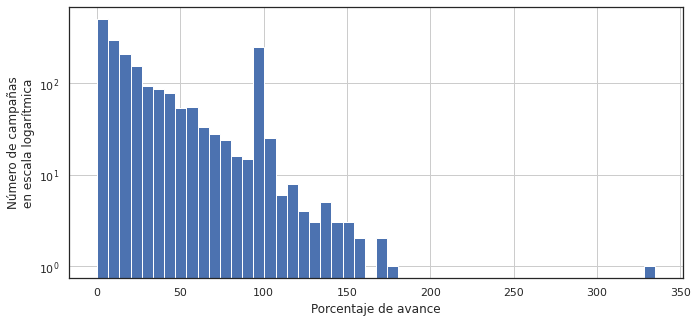

In [22]:
#arreglar esto (unique identifier)
ax = df.drop(labels = [477, 1706], axis=0).hist(column = ['percentage of completion'], bins = 50, log = True)

ax[0][0].set_ylabel('Número de campañas\nen escala logarítmica')
ax[0][0].set_xlabel('Porcentaje de avance')
ax[0][0].set_title('')
    
plt.show()
plt.show()

y agrupamos por tags:

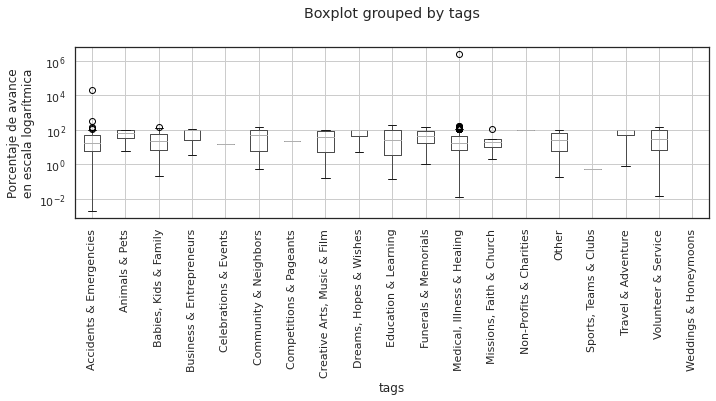

In [23]:
ax = df.boxplot(column = ['percentage of completion'], by = 'tags', 
                                    layout = (2, 1), rot = 90, figsize = (11, 7))
ax[0].set_ylabel('Porcentaje de avance\nen escala logarítmica')
ax[0].set_title('')
ax[0].set_yscale('log')
plt.show()

### Distribución de la tasa del número de donaciones:

In [24]:
df.sort_values(by=['donation_count'], ascending=False).head() # veamos si hay valores muy grandes

,tags,current amount,total_amount,currency used,current amount in dollars,total amount in dollars,percentage of completion,created,launch_date,country,donation_count,is_charity
1591,"Medical, Illness & Healing",160657,160657,USD,160657.0,160657.0,100.000000,"Created August 25, 2020",2020-08-25,US,1862,False
421,"Medical, Illness & Healing",29866,35000,USD,29866.0,35000.0,85.331429,"Created July 25, 2020",2020-07-25,US,1488,False
461,Funerals & Memorials,44068,100000,USD,44068.0,100000.0,44.068000,"Created August 19, 2020",2020-08-19,US,675,False
460,"Medical, Illness & Healing",12910,25000,USD,12910.0,25000.0,51.640000,"Created November 25, 2020",2020-11-25,US,583,False
436,Other,62421,75000,USD,62421.0,75000.0,83.228000,"Created February 16, 2020",2020-02-16,US,528,False


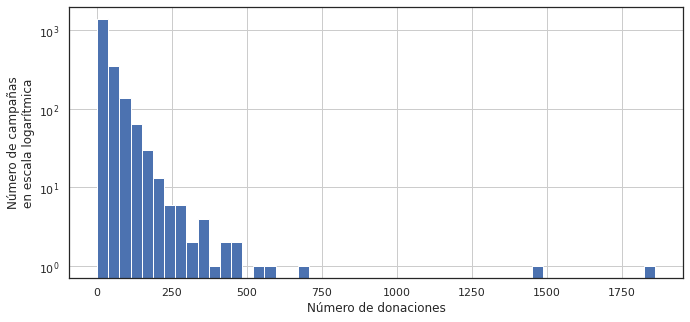

In [25]:
ax = df.hist(column = 'donation_count', bins = 50, log = True) #removemos los outliers
ax[0][0].set_ylabel('Número de campañas\nen escala logarítmica')
ax[0][0].set_xlabel('Número de donaciones')
ax[0][0].set_title('')
    
plt.show()
plt.show()

plt.show()

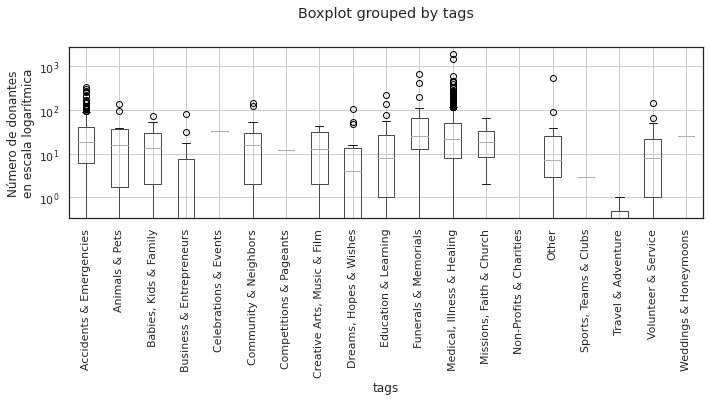

In [26]:
ax = df.boxplot(column = ['donation_count'], by = 'tags', layout = (2, 1), rot = 90, figsize = (11, 7))
ax[0].set_ylabel('Número de donantes\nen escala logarítmica')
ax[0].set_title('')
ax[0].set_yscale('log')
plt.show()

## Series de tiempo

### Número de nuevas campañas 

In [27]:
# creamos un DataFrame con la serie de tiempo de interés
df_campañas = df.reset_index().pivot_table(values = 'index', index = 'launch_date', columns = 'tags', 
                         aggfunc = pd.Series.nunique, fill_value = 0)
df_campañas.head()

tags,Accidents & Emergencies,Animals & Pets,"Babies, Kids & Family",Business & Entrepreneurs,Celebrations & Events,Community & Neighbors,Competitions & Pageants,"Creative Arts, Music & Film","Dreams, Hopes & Wishes",Education & Learning,Funerals & Memorials,"Medical, Illness & Healing","Missions, Faith & Church",Non-Profits & Charities,Other,"Sports, Teams & Clubs",Travel & Adventure,Volunteer & Service,Weddings & Honeymoons
launch_date,,,,,,,,,,,,,,,,,,,
2020-01-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-02-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2020-02-17,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-22,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2020-02-24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


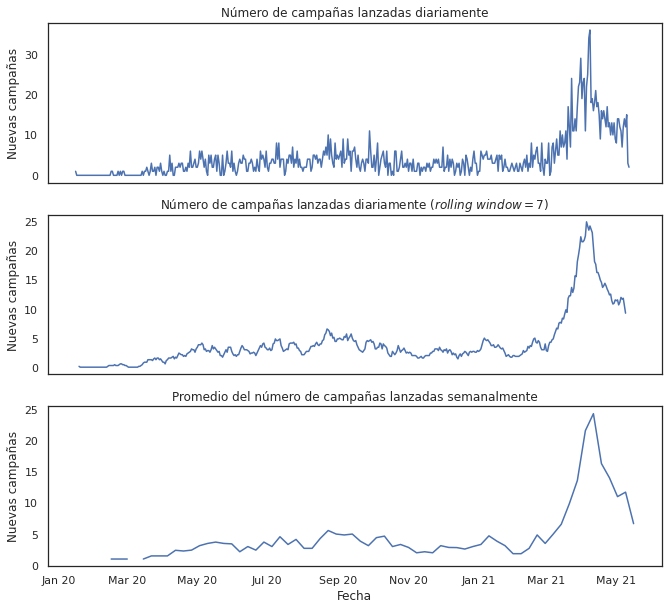

In [28]:
#tomamos muestras semanales y calculamos el promedio sobre estas muestra
serie_diaria = df_campañas.sum(axis = 1).resample('D').sum()
serie_rolling = serie_diaria.rolling(window=7, center=True).mean()
serie_semanal = df_campañas.sum(axis = 1).resample('W').mean()

#Graficamos la serie de tiempo
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

#serie_diaria
axes[0].plot(serie_diaria)
axes[0].set_title('Número de campañas lanzadas diariamente')

#serie_rolling
axes[1].plot(serie_rolling)
axes[1].set_title(r'Número de campañas lanzadas diariamente $(rolling$ $window=7) $')

#serie_semanal
axes[2].plot(serie_semanal)
axes[2].set_title(r'Promedio del número de campañas lanzadas semanalmente')

# Dar formato a las fechas
for ax in axes:
    ax.set_ylabel('Nuevas campañas') #agregamos label en el eje y

axes[2].set_xlabel('Fecha')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.tight_layout
plt.show()

Aquí se exploraron 3 formas diferentes de visualizar la serie de tiempo. Nos quedaremos con la segunda (*rolling window = 7*):

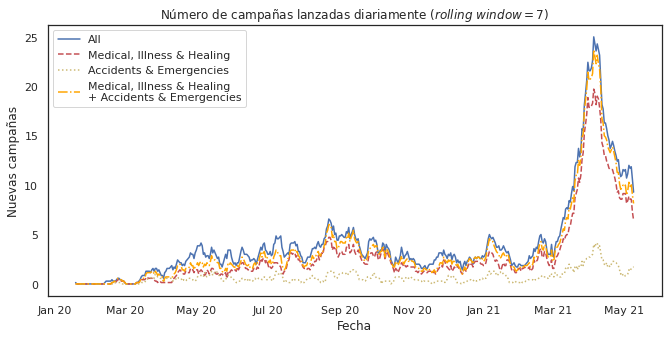

In [29]:
# creamos la figura
fig = plt.figure()
ax = fig.add_subplot(111)


# serie: total
serie_total = df_campañas.sum(axis = 1).resample('D').sum().rolling(window=7, center=True).mean()
ax.plot(serie_total, label = 'All')

# serie: Medical, illness & Healing
serie_salud = df_campañas['Medical, Illness & Healing'].resample('D').sum().rolling(window=7, center=True).mean()
ax.plot(serie_salud, label = 'Medical, Illness & Healing', ls = '--', color = 'r')

# serie: Accidents & Emergencies
serie_emergencia = df_campañas['Accidents & Emergencies'].resample('D').sum().rolling(window=7, center=True).mean()
ax.plot(serie_emergencia, label = 'Accidents & Emergencies', ls = ':', color = 'y')

# serie: Medical, illness & Healing + Accidents & Emergencies 
ax.plot(serie_salud + serie_emergencia, label = 'Medical, Illness & Healing\n+ Accidents & Emergencies', ls =  '-.',
        color = 'orange')

ax.set_title(r'Número de campañas lanzadas diariamente $(rolling$ $window=7) $')

ax.set_ylabel('Nuevas campañas')
ax.set_xlabel('Fecha')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.legend()
plt.show()

#se exportan las series de tiempo
columns = ['All', 'Medical, Illness & Healing', 'Accidents & Emergencies', 
           'Medical, Illness & Healing + Accidents & Emergencies']
df_exp = pd.concat([serie_total, serie_salud, serie_emergencia, 
                     serie_salud + serie_emergencia], axis=1).set_axis(columns, axis = 1).iloc[3:-3,:]
df_exp.to_csv('../datos/series_GoFundMe.csv') #escribimos el df

In [30]:
df_exp.head() #visualizamos los que exportamos 

,All,"Medical, Illness & Healing",Accidents & Emergencies,"Medical, Illness & Healing + Accidents & Emergencies"
launch_date,,,,
2020-01-19,0.142857,0.0,0.0,0.0
2020-01-20,0.000000,0.0,0.0,0.0
2020-01-21,0.000000,0.0,0.0,0.0
2020-01-22,0.000000,0.0,0.0,0.0
2020-01-23,0.000000,0.0,0.0,0.0


### Total del costo de las campañas lanzadas diariamente:

In [31]:
# creamos un DataFrame con la serie de tiempo de interés
dfmod = df.drop(labels=1054, axis=0) # eliminamos la campaña considerablemente costosa
df_costo_total = dfmod.pivot_table(values = 'total amount in dollars', index = 'launch_date', columns = 'tags', 
                         aggfunc = np.sum, fill_value = 0)
df_costo_total.head()

tags,Accidents & Emergencies,Animals & Pets,"Babies, Kids & Family",Business & Entrepreneurs,Celebrations & Events,Community & Neighbors,Competitions & Pageants,"Creative Arts, Music & Film","Dreams, Hopes & Wishes",Education & Learning,Funerals & Memorials,"Medical, Illness & Healing","Missions, Faith & Church",Non-Profits & Charities,Other,"Sports, Teams & Clubs",Travel & Adventure,Volunteer & Service,Weddings & Honeymoons
launch_date,,,,,,,,,,,,,,,,,,,
2020-01-16,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,10000.0,0,0.0,0.0,0
2020-02-16,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,75000.0,0,0.0,0.0,0
2020-02-17,0.0,0.0,5000.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0
2020-02-22,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,5000.0,0.0,0,0.0,0,0.0,0.0,0
2020-02-24,2500.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0


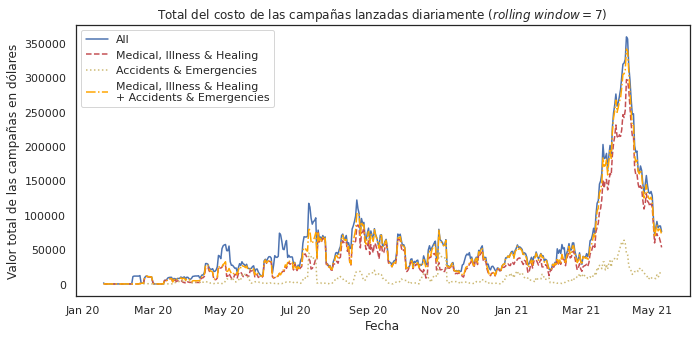

In [32]:
# creamos la figura
fig = plt.figure()
ax = fig.add_subplot(111)


# serie: total
serie_total = df_costo_total.sum(axis = 1).resample('D').sum().rolling(window=7, center=True).mean()
plt.plot(serie_total, label = 'All')

# serie: Medical, illness & Healing
serie_salud = df_costo_total['Medical, Illness & Healing'].resample('D').sum().rolling(window=7, center=True).mean()
plt.plot(serie_salud, label = 'Medical, Illness & Healing', ls = '--', color = 'r')

# serie: Accidents & Emergencies
serie_emergencia = df_costo_total['Accidents & Emergencies'].resample('D').sum().rolling(window=7, center=True).mean()
plt.plot(serie_emergencia, label = 'Accidents & Emergencies', ls = ':', color = 'y')

# serie: Medical, illness & Healing + Accidents & Emergencies 
plt.plot(serie_salud + serie_emergencia, label = 'Medical, Illness & Healing\n+ Accidents & Emergencies', ls = '-.', 
         color = 'orange')

plt.title(r'Total del costo de las campañas lanzadas diariamente $(rolling$ $window=7) $')

ax.set_ylabel('Valor total de las campañas en dólares')
ax.set_xlabel('Fecha')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.legend()
plt.show()

### Valor promedio de las campañas lanzadas diariamente:

In [33]:
df_costo_prom = dfmod.pivot_table(values = 'total amount in dollars', index = 'launch_date', columns = 'tags', 
                         aggfunc = np.mean, fill_value = 0)
df_costo_prom.head()

tags,Accidents & Emergencies,Animals & Pets,"Babies, Kids & Family",Business & Entrepreneurs,Celebrations & Events,Community & Neighbors,Competitions & Pageants,"Creative Arts, Music & Film","Dreams, Hopes & Wishes",Education & Learning,Funerals & Memorials,"Medical, Illness & Healing","Missions, Faith & Church",Non-Profits & Charities,Other,"Sports, Teams & Clubs",Travel & Adventure,Volunteer & Service
launch_date,,,,,,,,,,,,,,,,,,
2020-01-16,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,10000.0,0,0.0,0.0
2020-02-16,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,75000.0,0,0.0,0.0
2020-02-17,0.0,0.0,5000.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,5000.0,0.0,0,0.0,0,0.0,0.0
2020-02-24,2500.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0


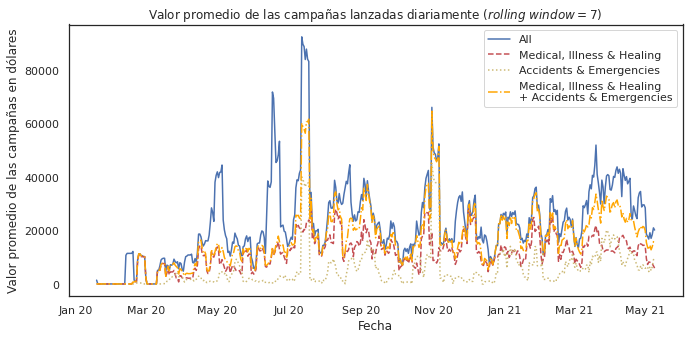

In [34]:
# creamos la figura
fig = plt.figure()
ax = fig.add_subplot(111)


# serie: total
serie_total = df_costo_prom.sum(axis = 1).resample('D').sum().rolling(window=7, center=True).mean()
plt.plot(serie_total, label = 'All')

# serie: Medical, illness & Healing
serie_salud = df_costo_prom['Medical, Illness & Healing'].resample('D').sum().rolling(window=7, center=True).mean()
plt.plot(serie_salud, label = 'Medical, Illness & Healing', ls = '--', color = 'r')

# serie: Accidents & Emergencies
serie_emergencia = df_costo_prom['Accidents & Emergencies'].resample('D').sum().rolling(window=7, center=True).mean()
plt.plot(serie_emergencia, label = 'Accidents & Emergencies', ls = ':', color = 'y')

# serie: Medical, illness & Healing + Accidents & Emergencies 
plt.plot(serie_salud + serie_emergencia, label = 'Medical, Illness & Healing\n+ Accidents & Emergencies', ls = '-.', 
         color = 'orange')

plt.title(r'Valor promedio de las campañas lanzadas diariamente $(rolling$ $window=7) $')

ax.set_ylabel('Valor promedio de las campañas en dólares')
ax.set_xlabel('Fecha')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.legend()
plt.show()